In [18]:
import pandas as pd, numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%a\n%m/%d')

import seaborn as sns

In [19]:
pd.options.display.max_rows = 999

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Import COVID data from the NY Times
path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
covid = pd.read_csv(path)
covid['date'] = pd.to_datetime(covid.date)

# Import census population data by county for 2018
path = 'http://www.wtad.com/assets/news_files/PEP_2018_PEPANNCHG.ST05_with_ann.xlsx'
pop = pd.read_excel(path)
pop = pop.rename(columns={'GC.target-geo-id2':'fips',
                'respop72018':'population'})
pop = pop[['fips','population']]
pop = pop.loc[1:]
pop['population'] = pd.to_numeric(pop['population'])
pop['fips'] = pd.to_numeric(pop.fips)

In [22]:
# Import MSA mapping 
# Clean up MSA names to keep the major city and state
path = "https://raw.githubusercontent.com/dri3s/covidviz/master/metrolist.csv"
msa = pd.read_csv(path, nrows=1160, header=None, names=['msa_fips','msa_name','fips','county_name'])

msa.fips = pd.to_numeric(msa['fips'])
msa = msa.drop(columns=['msa_fips','county_name'])

msasplit = msa.msa_name.str.split(pat=',|-', expand=True)
msasplit['state'] = None

for idx, row in msasplit.iterrows():
    for col in row:
        try:
            state = col.strip()[0:2]
            if state.isupper() and msasplit.loc[idx, 'state'] == None:
                msasplit.loc[idx, 'state'] = state
                continue
        except:
            continue

msasplit = msasplit.rename(columns={0:'city'})

msasplit = msasplit[['city','state']]
msa[['city','state']] = msasplit
msa['msa_name'] = msa.city + ', ' + msa.state

In [23]:
# Make sure there are records for every single day - fill null values with zeroes
calshell = pd.DataFrame(covid.date.unique(), columns=['date'])
calshell['key'] = 1
pop['key'] = 1
covidmsa = calshell.merge(pop).merge(msa).merge(covid, how='left', on=['fips','date'])
covidmsa = covidmsa.fillna(0)

In [24]:
# Combine covid, population, and MSA data
# Sum by MSA and compute cases per capita
covidmsa = covidmsa.drop(columns=['fips','key']).groupby(['date','msa_name']).sum().reset_index()
covidmsa['caseperk'] = (covidmsa.cases/covidmsa['population']) * 1000
covidmsa = covidmsa.sort_values(by=['msa_name','date']).reset_index(drop=True)
covidmsa = covidmsa.loc[covidmsa.cases >= 10]
covidmsa ['num_days'] = (covidmsa.date - covidmsa.groupby(['msa_name'])['date'].transform('min')).dt.days

In [25]:
def GetDouble(df):
    df['lncase'] = np.log(df.cases)
    df = df.sort_values(by='date')

    X = df.tail(5).num_days.values.reshape(-1, 1)
    y = df.tail(5).lncase.values

    reg = LinearRegression().fit(X, y)

    return round(np.log(2)/reg.coef_[0], 1)

doubling = covidmsa.groupby('msa_name').apply(lambda x: GetDouble(x)).reset_index()
doubling = doubling.rename(columns={0: 'doubling'})
doubling = doubling.loc[doubling.doubling != np.inf]
doubling = doubling.sort_values(by='doubling').reset_index(drop=True)

<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)
<ipython-input-25-a760c68a3ad6>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return round(np.log(2)/reg.coef_[0], 1)


In [26]:
worst = doubling.head(10).msa_name.tolist()

In [27]:
doubling

,msa_name,doubling
0,"Sioux City, IA",1.7
1,"Green Bay, WI",3.4
2,"St. Cloud, MN",4.0
3,"Cumberland, MD",4.5
4,"Janesville, WI",4.5
5,"Yuma, AZ",4.6
6,"Waterloo, IA",4.6
7,"Amarillo, TX",4.9
8,"Hanford, CA",5.1
9,"Walla Walla, WA",5.4


In [28]:
doubling.loc[doubling.msa_name.str.contains('TX')]

,msa_name,doubling
7,"Amarillo, TX",4.9
53,"Abilene, TX",10.2
57,"El Paso, TX",10.5
100,"Killeen, TX",12.9
135,"Dallas, TX",15.6
143,"Victoria, TX",16.1
146,"Beaumont, TX",16.5
154,"Longview, TX",16.7
164,"Laredo, TX",17.5
180,"Austin, TX",18.5


In [29]:
# Mark the 10 worst MSAs and include others of interest
#worst = list(covidmsa.groupby('msa_name').
#             caseperk.max().reset_index().
#             sort_values('caseperk').tail(10).msa_name.values)

In [30]:
dets = list(covidmsa.loc[covidmsa.msa_name.str.contains('Dallas')].msa_name.unique())
dets.append(covidmsa.loc[covidmsa.msa_name.str.contains('Houston')].msa_name.unique()[0])

# These are cities with quarantine facilities that had lots of patients early on 
# They are outliers and should be excluded
exclude = ['San Antonio, TX','Omaha, NE','Vallejo, CA']

Text(0.9, 0.01, 'Data current through 04/25')

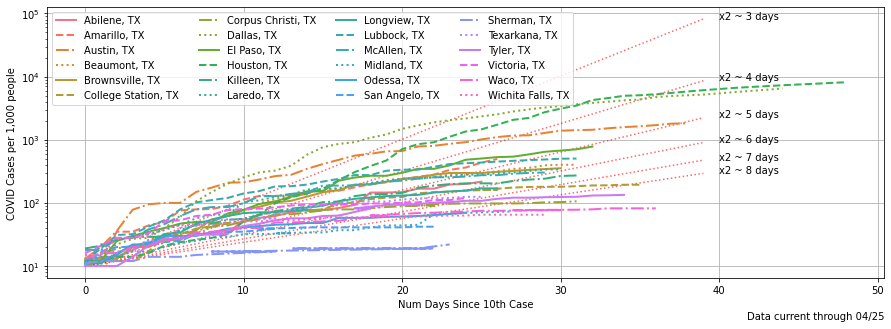

In [31]:
tx = covidmsa.loc[covidmsa.msa_name.str.contains('TX')].msa_name.unique().tolist()

graph = tx
colors = iter(sns.color_palette('husl', len(graph)))

lss = ['-','--','-.',':']
lss = iter(lss * (int(len(graph)/len(lss)) + 1))

# Compute doubling rate comparisons and graph
exp = pd.DataFrame(np.arange(40), columns=['num_days'])
ds = list(range(3, 9))
for d in ds:
    exp['double{}'.format(d)] = 10 * np.exp(exp.num_days * (np.log(2)/d))
    
plt.rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots()

for d in ds:
    ys = exp['double{}'.format(d)]
    ax.plot(exp.num_days, ys, ls='dotted', color='red', label='_nolabel_', alpha=0.6)
    plt.text(exp.num_days.max() + 1, ys.max(), 'x2 ~ {} days'.format(d))

for msaname, df in covidmsa.groupby('msa_name'):    
    if msaname in exclude:
        continue
    
    df = df.sort_values(by='caseperk')
    
    #if msaname in worst or msaname in dets:
    if msaname in graph:
        label = msaname
        color = next(colors)
        ls = next(lss)
        lw, alpha = (2, 1)
    else:   
        continue
        label = '_nolabel_'
        color='gray'
        lw, alpha = (0.4, 0.4)
        ls = '-'
    
    #ax.plot(covidmsa.loc[covidmsa.fips == fips]['date'],
    ax.plot(df['num_days'],
            df['cases'], 
            label=label,
            color=color,
            lw=lw,
            alpha=alpha,
            ls = ls
            )    
    
    
#ax.set_xlim([pd.to_datetime('15feb2020'),pd.to_datetime(date.today())])
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.MO))

#ax.set_xlim([0, covidmsa.num_days.max()])

ax.set_yscale('log', basey=10)

ax.set_ylabel('COVID Cases per 1,000 people')
ax.set_xlabel('Num Days Since 10th Case')
ax.legend(ncol = 4)
ax.grid()

plt.figtext(0.9, 0.01, 'Data current through {:%m/%d}'.format(covidmsa.date.max()), horizontalalignment='right') 

Text(0.5, 1.0, 'Houston Metro COVID Case Count')

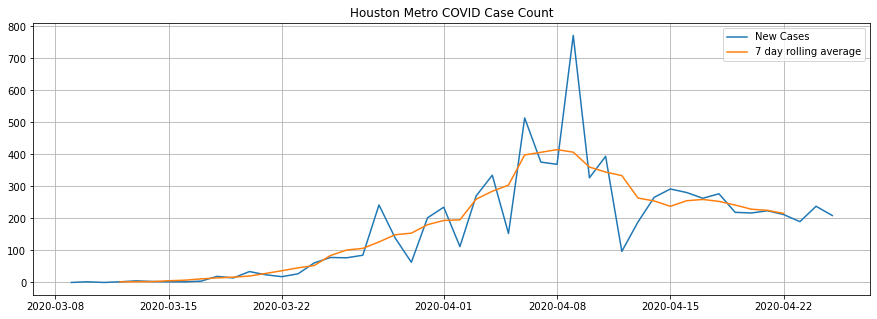

In [34]:
h = covidmsa.loc[covidmsa.msa_name == 'Houston, TX'].reset_index(drop=True)

h['new_cases'] = h.cases - h['cases'].shift()

fig, ax = plt.subplots()
ax.plot(h.date, h.new_cases, label='New Cases')
ax.plot(h.date, h.new_cases.rolling(7, center=True).mean(), label='7 day rolling average')
ax.grid()
ax.legend()
ax.set_title('Houston Metro COVID Case Count')